In [ ]:
from google.colab import drive
drive.mount("/content/drive/")

Mounted at /content/drive/


In [ ]:
%cd /content/drive/MyDrive/WorkSpace/AI_Research/Emotion/code/

/content/drive/MyDrive/WorkSpace/AI_Research/Emotion/code


In [ ]:
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
# from lr_finder import LRFinder
from utils.processing import data_processing
from utils import get_models
from utils import optimizers
from utils.datasets import data_generator
from utils.processing import data_augmentation
from utils import predict
from utils import attention_module

import json
import numpy as np
import keras
import tensorflow as tf
from keras import layers, Input
from keras.utils import np_utils 

from tensorflow.keras.models import Sequential, model_from_json
from tensorflow.keras.applications import VGG16, ResNet50, VGG19, ResNet50V2, MobileNetV2, MobileNetV2
from tensorflow.keras.optimizers import Adam, Adamax
from keras.models import load_model, Model



## Set_config


In [ ]:
default_ws_dir =  "/content/drive/MyDrive/WorkSpace/AI_Research/Emotion"
configfer = json.load(open(f"{default_ws_dir}/code/configs/ferplus_config.json"))
config_train = json.load(open(f"{default_ws_dir}/code/configs/wb_config.json"))

In [ ]:
# !pip install wandb -qqq
# from wandb.keras import WandbCallback
# import wandb

In [ ]:
# # Log in to your W&B account
# wandb.login()

In [ ]:
# run = wandb.init(project='My_research',
#                  config=config_train)
# config = wandb.config 

##Load data

In [ ]:
# Get data
emotion = ["Neutral" , "Happiness", "Surprise", "Sadness", "Anger", "Disgust" , "Fear"  ]
X , y = data_processing.get_ferpus()
X, y = data_processing.ferplus_processing(X,y)
y_new = data_processing.majority_vote(y)
# X_train,y_train, X_test, y_test = data_processing.split_data(X,y_new)

In [ ]:
# Offline augmentation
X_train, y_train, X_val, y_val, X_test, y_test= data_processing.split_data(X,y_new)

X_train, y_train = data_augmentation.aug_offline(X_train, y_train, num_class = 5, number_aug = 8)
X_train, y_train = data_augmentation.aug_offline(X_train, y_train, num_class = 6, number_aug =5)

X_train, y_train = shuffle(X_train, y_train)

In [ ]:
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(33196, 48, 48, 1)
(3549, 48, 48, 1)
(3549, 48, 48, 1)


## Data generator

In [ ]:
img_size = 48

In [ ]:
params_train = {
          'config': configfer,
          'shuffle': True,
          'augmentation': True}
params_val = {
          'config': configfer,
          'shuffle': None,
          'augmentation': None}         

train_ds = data_generator.DataGenerator(X_train, y_train, **params_train ).to_dataset(data_type = "train")
val_ds = data_generator.DataGenerator(X_val, y_val, **params_val).to_dataset(data_type = "val")
test_ds = data_generator.DataGenerator(X_test, y_test, **params_val).to_dataset(data_type = "val", batch_size = 1)

In [ ]:
train_ds

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 48, 48, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None, 7), dtype=tf.float32, name=None))>

In [ ]:
batch1 , batch2 = val_ds.take(2)

In [ ]:
# Create input shape
img_size_target = img_size
img_input = Input(shape=(img_size_target, img_size_target, 1))
img_conc = layers.Concatenate()([img_input, img_input, img_input])
img_conc

<KerasTensor: shape=(None, 48, 48, 3) dtype=float32 (created by layer 'concatenate_5')>

In [ ]:
opt = optimizers.RAdam(config_train["learning_rate"])

In [ ]:
model = get_models.Pre_train_model(VGG16, img_conc, None)

# model.load_weights("/content/drive/MyDrive/WorkSpace/AI_Research/Emotion/checkpoints/FerPlusV11.hdf5")
model.compile(loss =config_train["loss"], optimizer =opt, metrics=[config_train["metric"]])
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=tf.math.exp(-0.1),
                              patience=3, min_lr=0 , verbose =1)

files = configfer["file_checkpoint"]
checkpoint_filepath = (f"{default_ws_dir}/checkpoints/{files}")

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    verbose= 1,
    monitor='val_accuracy',
    mode='auto',
    save_best_only=True, save_weights_only = True)


In [ ]:
class_weights = {
    0 : 1.02660468,
    1 : 9.40661861,
    2 : 1.00104606,
    3 : 0.56843877,
    4 : 0.84912748,
    5 : 1.29337298,
    6 : 0.82603942,
}

In [ ]:
H = model.fit(train_ds,steps_per_epoch = 1037, validation_data=val_ds, class_weight = class_weights,
            epochs=config_train["epochs"], verbose = 1, callbacks = [reduce_lr,model_checkpoint])


Epoch 1/100
1037/1037 [==============================] - ETA: 0s - loss: 3.1378 - accuracy: 0.2442
Epoch 1: val_accuracy improved from -inf to 0.42153, saving model to /content/drive/MyDrive/WorkSpace/AI_Research/Emotion/checkpoints/ferplus_vgg16_v1.hdf5
1037/1037 [==============================] - 94s 85ms/step - loss: 3.1378 - accuracy: 0.2442 - val_loss: 1.8140 - val_accuracy: 0.4215 - lr: 3.0000e-04
Epoch 2/100
1037/1037 [==============================] - ETA: 0s - loss: 2.3534 - accuracy: 0.3602
Epoch 2: val_accuracy improved from 0.42153 to 0.53846, saving model to /content/drive/MyDrive/WorkSpace/AI_Research/Emotion/checkpoints/ferplus_vgg16_v1.hdf5
1037/1037 [==============================] - 88s 85ms/step - loss: 2.3534 - accuracy: 0.3602 - val_loss: 1.6524 - val_accuracy: 0.5385 - lr: 3.0000e-04
Epoch 3/100
1037/1037 [==============================] - ETA: 0s - loss: 2.1819 - accuracy: 0.4150
Epoch 3: val_accuracy improved from 0.53846 to 0.65540, saving model to /content/dri

# Evaluate

In [ ]:

model = get_models.Pre_train_model(ResNet50, img_conc, None)

model.compile(loss ="categorical_crossentropy", optimizer =Adamax(3e-7), metrics=["accuracy"])
model.load_weights("/content/drive/MyDrive/WorkSpace/AI_Research/Emotion/checkpoints/FerPlusV11.hdf5")

In [ ]:
model.evaluate(test_ds)

3549/3549 [==============================] - 37s 10ms/step - loss: 0.8647 - accuracy: 0.8431


[0.8647233843803406, 0.8430543541908264]

In [ ]:
images , test_labels = predict.get_imgs_test(test_ds)

+ precision = 0.796
+ recall = 0.752
+ f1_score = 0.772


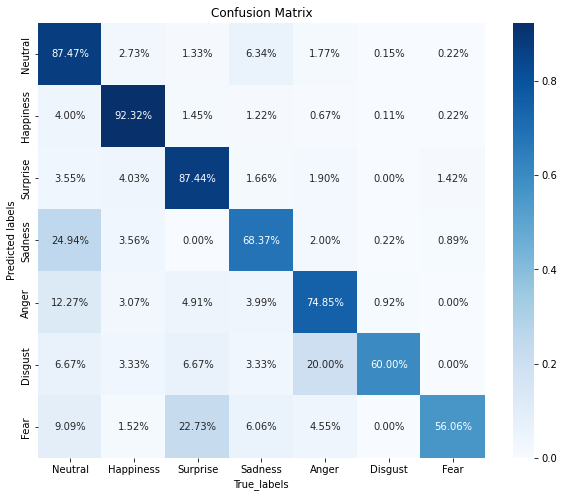

In [ ]:
get_models.Confusion_Matrix(model , images, test_labels ,  emotion, mode = True)

In [ ]:
model = get_models.Pre_train_model(ResNet50, img_conc, None)

# model.load_weights("/content/drive/MyDrive/WorkSpace/AI_Research/Emotion/checkpoints/FerPlusV11.hdf5")
model.compile(loss ="categorical_crossentropy", optimizer =Adamax(1e-4), metrics=["accuracy"])
# EarlyStopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                              patience=3, min_lr=0 , verbose =1)

checkpoint_filepath = "/content/drive/MyDrive/WorkSpace/AI_Research/Emotion/checkpoints/FerPlusV13.hdf5"
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    verbose= 1,
    monitor='val_accuracy',
    mode='auto',
    save_best_only=True, save_weights_only = True)

In [ ]:
 H = model.fit(train_ds, validation_data=val_ds, steps_per_epoch= 1050*2,
              epochs=50, verbose = 1, callbacks = [reduce_lr,model_checkpoint ])

Epoch 1/50
2100/2100 [==============================] - ETA: 0s - loss: 2.3679 - accuracy: 0.4200
Epoch 1: val_accuracy improved from -inf to 0.59236, saving model to /content/drive/MyDrive/WorkSpace/AI_Research/Emotion/checkpoints/FerPlusV13.hdf5
2100/2100 [==============================] - 200s 93ms/step - loss: 2.3679 - accuracy: 0.4200 - val_loss: 1.9279 - val_accuracy: 0.5924 - lr: 1.0000e-04
Epoch 2/50
2100/2100 [==============================] - ETA: 0s - loss: 1.9845 - accuracy: 0.5730
Epoch 2: val_accuracy improved from 0.59236 to 0.67877, saving model to /content/drive/MyDrive/WorkSpace/AI_Research/Emotion/checkpoints/FerPlusV13.hdf5
2100/2100 [==============================] - 198s 94ms/step - loss: 1.9845 - accuracy: 0.5730 - val_loss: 1.6870 - val_accuracy: 0.6788 - lr: 1.0000e-04
Epoch 3/50
2100/2100 [==============================] - ETA: 0s - loss: 1.7885 - accuracy: 0.6378
Epoch 3: val_accuracy improved from 0.67877 to 0.70914, saving model to /content/drive/MyDrive/Wo

# Attention VGG16

V4 loss: 0.3803 - accuracy: 0.8849 - val_loss: 0.5540 - val_accuracy: 0.8392 - lr: 3.0000e-10


v5 loss: 0.3895 - accuracy: 0.8841 - val_loss: 0.5540 - val_accuracy: 0.8413 - lr: 3.0000e-29


In [ ]:
!pip install attention

In [ ]:
from keras.applications.vgg16 import VGG16
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten, Input, Conv2D, multiply, LocallyConnected2D, Lambda
from keras.models import Model
from keras.layers import BatchNormalization
# in_lay = Input((128,128,3))
base_pretrained_model = VGG16(input_shape = None, input_tensor = img_conc ,
                              include_top = False, weights = 'imagenet')
input = base_pretrained_model.input 
# base_pretrained_model.trainable = 

pt_depth = base_pretrained_model.layers[-1].output_shape[-1]
pt_features = base_pretrained_model.layers[-1].output

bn_features = BatchNormalization()(pt_features)

print(pt_features)
# here we do an attention mechanism to turn pixels in the GAP on an off
'''
'''

attn_layer = Conv2D(64, kernel_size = (1,1), padding = 'same', activation = 'relu')(bn_features)
attn_layer = Conv2D(16, kernel_size = (1,1), padding = 'same', activation = 'relu')(attn_layer)
attn_layer = Conv2D(1, kernel_size = (1,1), padding = 'valid', activation = 'sigmoid')(attn_layer)

# fan it out to all of the channels
up_c2_w = np.ones((1, 1, 1, pt_depth))
up_c2 = Conv2D(pt_depth, kernel_size = (1,1), padding = 'same', 
               activation = 'linear', use_bias = False, weights = [up_c2_w])
up_c2.trainable = False
attn_layer = up_c2(attn_layer)

mask_features = multiply([attn_layer, bn_features])
gap_features = GlobalAveragePooling2D()(mask_features)
gap_mask = GlobalAveragePooling2D()(attn_layer)
# to account for missing values from the attention model

gap = Lambda(lambda x: x[0]/x[1], name = 'RescaleGAP')([gap_features, gap_mask])


###
gap_dr = Dropout(0.5)(gap)

dr_steps = Dropout(0.25)(gap_dr)
dr_steps = (Dense(512, activation = 'relu',  kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4),
                    bias_regularizer=regularizers.L2(1e-4),
                    activity_regularizer=regularizers.L2(1e-5)))(dr_steps)
dr_steps = Dropout(0.25)(dr_steps)
dr_steps = (Dense(128, activation = 'relu',  kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4),
                    bias_regularizer=regularizers.L2(1e-4),
                    activity_regularizer=regularizers.L2(1e-5)))(dr_steps)


out_layer = Dense(7, activation = 'softmax')(dr_steps)

tb_model = Model(inputs = input, outputs = out_layer)
tb_model.summary()


In [ ]:
# model = get_models.Pre_train_model(VGG16, img_conc, None)


tb_model.compile(loss ="categorical_crossentropy", optimizer =Adamax(3e-4), metrics=["accuracy"])
# EarlyStopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                              patience=3, min_lr=0 , verbose =1)

checkpoint_filepath = "/content/drive/MyDrive/WorkSpace/AI_Research/Emotion/checkpoints/FerplusGAPv1.hdf5"
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    verbose= 1,
    monitor='val_accuracy',
    mode='auto',
    save_best_only=True, save_weights_only = True)


In [ ]:
H = tb_model.fit(train_ds, validation_data=val_ds, 
              epochs=100, verbose = 1, callbacks = [reduce_lr,model_checkpoint ])

In [ ]:
model = get_models.Pre_train_model(ResNet50, img_conc, None)

In [ ]:
model.summary()

In [ ]:
!pip install git+https://github.com/paulgavrikov/visualkeras

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/paulgavrikov/visualkeras to /tmp/pip-req-build-rb92j4s8
  Running command git clone -q https://github.com/paulgavrikov/visualkeras /tmp/pip-req-build-rb92j4s8
     |████████████████████████████████| 992 kB 5.1 MB/s 
  Created wheel for visualkeras: filename=visualkeras-0.0.2-py3-none-any.whl size=13449 sha256=1e2faecc39a3231cc302af6d75db421e3c769d17810ac510b52f6346c0af7666
  Stored in directory: /tmp/pip-ephem-wheel-cache-al7gzl6r/wheels/b8/3b/cf/30a062e766188d5fe50abf3d461720943b7d09906e3d261a94
Successfully built visualkeras


In [ ]:
import visualkeras
from PIL import ImageFont

from collections import defaultdict

color_map = defaultdict(dict)
color_map[Conv2D]['fill'] = 'orange'
# color_map[ZeroPadding2D]['fill'] = 'gray'
color_map[Dropout]['fill'] = 'blue'
color_map[MaxPooling2D]['fill'] = 'red'
color_map[Dense]['fill'] = 'green'
color_map[Flatten]['fill'] = 'teal'


# font = ImageFont.truetype("arial.ttf", 32)  # using comic sans is strictly prohibited!
visualkeras.layered_view(model, legend=True ,  type_ignore=[BatchNormalization, Activation, Dropout, Flatten] , spacing=10, color_map=color_map, scale_xy=6 , scale_z=6, max_z=1, to_file="/content/ResNet50v1.png" )  # font is optional!


In [ ]:
model = Sequential()
# 1st stage
model.add(Conv2D(64, kernel_size=(3, 3), input_shape=(48,48,1)))
model.add(BatchNormalization())
model.add(Activation(activation='relu'))
model.add(Conv2D(64, kernel_size=(3, 3)))
model.add(BatchNormalization())
model.add(Activation(activation='relu'))
model.add(Dropout(0.5))

# 2nd stage
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

# 3rd stage
model.add(Conv2D(2 * 64, kernel_size=(3, 3)))
model.add(BatchNormalization())
model.add(Activation(activation='relu'))
model.add(Conv2D(2 * 64, kernel_size=(3, 3)))
model.add(BatchNormalization())
model.add(Activation(activation='relu'))

# 4th stage
model.add(Conv2D(2 * 64, (3, 3), activation='relu'))
model.add(Conv2D(2 * 64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

# 5th stage
model.add(Conv2D(4 * 64, kernel_size=(3, 3)))
model.add(BatchNormalization())
model.add(Activation(activation='relu'))
model.add(Conv2D(4 * 64, kernel_size=(3, 3)))
model.add(BatchNormalization())
model.add(Activation(activation='relu'))

model.add(Flatten())

# Fully connected neural networks
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(7, activation='softmax'))

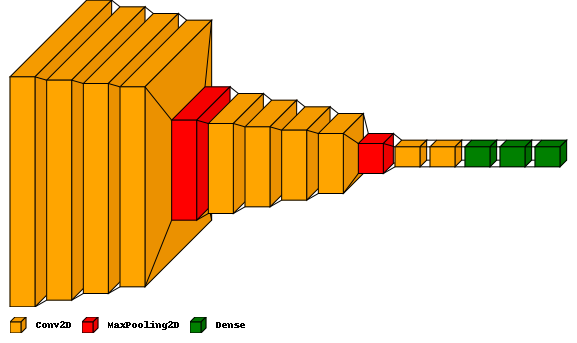

In [ ]:
import visualkeras
from PIL import ImageFont

from collections import defaultdict

color_map = defaultdict(dict)
color_map[Conv2D]['fill'] = 'orange'
# color_map[ZeroPadding2D]['fill'] = 'gray'
color_map[Dropout]['fill'] = 'blue'
color_map[MaxPooling2D]['fill'] = 'red'
color_map[Dense]['fill'] = 'green'
color_map[Flatten]['fill'] = 'teal'


# font = ImageFont.truetype("arial.ttf", 32)  # using comic sans is strictly prohibited!
visualkeras.layered_view(model, legend=True ,  type_ignore=[BatchNormalization, Activation, Dropout, Flatten] , spacing=10, color_map=color_map, scale_xy=5 , scale_z=5, max_z=25, to_file="/content/CNN.png" )  # font is optional!
